# Customer Churn Analysis

This notebook provides an analysis of customer churn.  
Models compared: Logistic Regression, Random Forest, and XGBoost.  
Focus is on data visualization and model performance metrics.

In [4]:
import pandas as pd
import numpy as np

df = pd.read_csv('/home/subaru/customer-churn/data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

df.drop("customerID", axis=1, inplace=True)

from sklearn.preprocessing import LabelEncoder

for col in df.select_dtypes(include=['object']).columns:
    if col != "Churn":
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])

df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

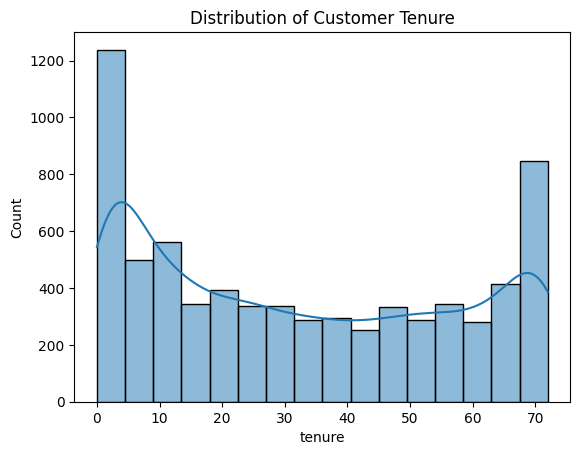

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df['tenure'], kde=True)
plt.title("Distribution of Customer Tenure")
plt.show()

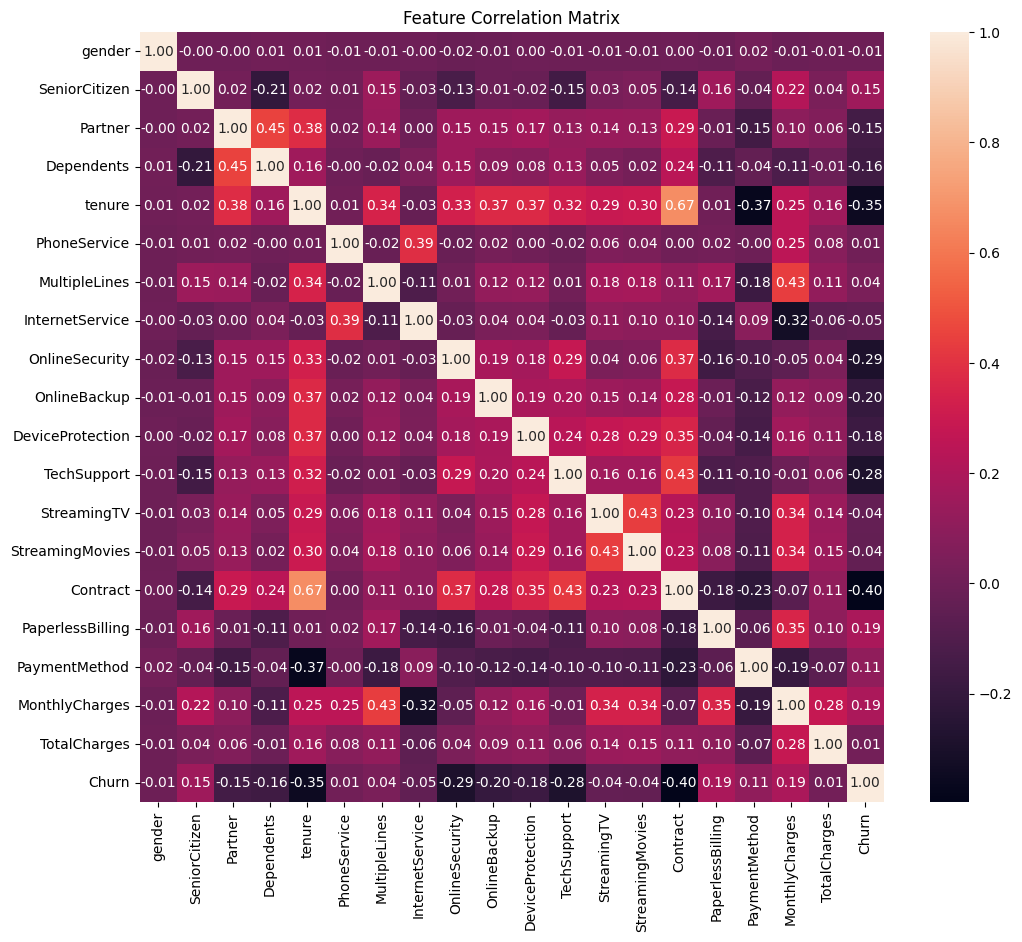

In [7]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=True, fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

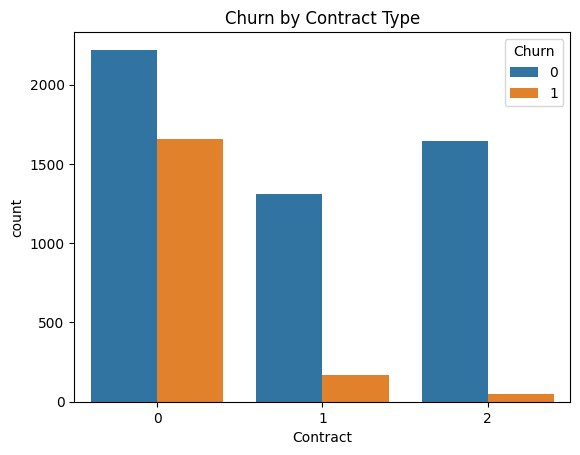

In [8]:
sns.countplot(x='Contract', hue='Churn', data=df)
plt.title("Churn by Contract Type")
plt.show()


In [12]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

X = df.drop('Churn', axis=1)
y = df['Churn']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced"),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    results[name] = {
        "model": model,
        "accuracy": accuracy_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_proba),
        "y_pred": y_pred,
        "y_proba": y_proba
    }



In [13]:
df_results = pd.DataFrame([
    {"Model": name,
     "Accuracy": round(res["accuracy"], 3),
     "F1": round(res["f1"], 3),
     "ROC-AUC": round(res["roc_auc"], 3)}
    for name, res in results.items()
])
df_results


,Model,Accuracy,F1,ROC-AUC
0,Logistic Regression,0.740,0.613,0.836
1,Random Forest,0.769,0.570,0.818
2,XGBoost,0.783,0.598,0.816


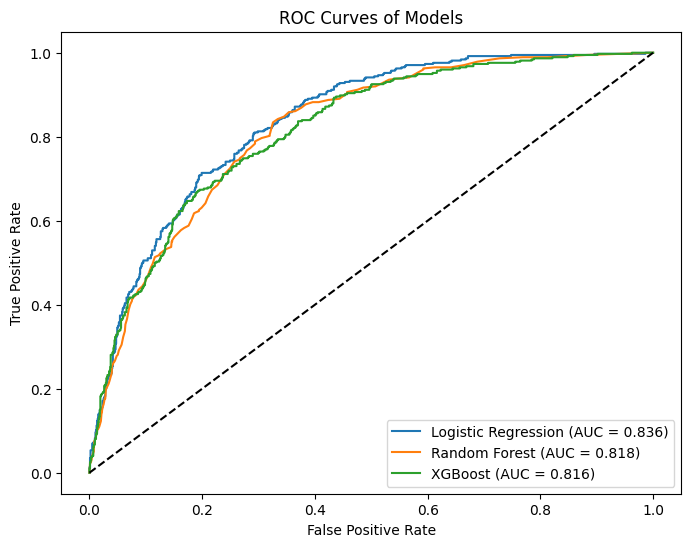

In [14]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8,6))
for name, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res["y_proba"])
    plt.plot(fpr, tpr, label=f"{name} (AUC = {res['roc_auc']:.3f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves of Models")
plt.legend()
plt.show()


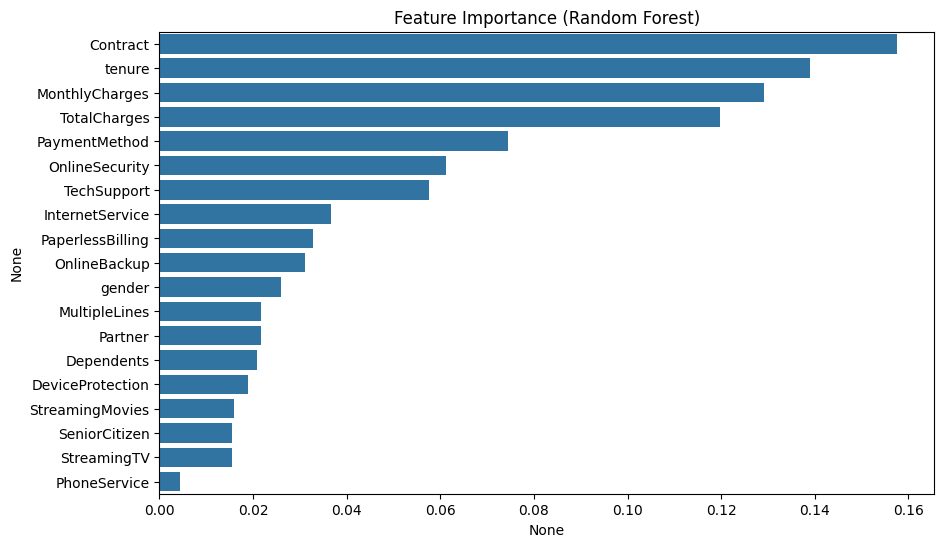

In [15]:
importances = results["Random Forest"]["model"].feature_importances_
features = df.drop('Churn', axis=1).columns
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp, y=feat_imp.index)
plt.title("Feature Importance (Random Forest)")
plt.show()


- Logistic Regression achieved the best F1 and ROC-AUC scores, which are critical for predicting customer churn.
- Random Forest slightly outperforms in Accuracy but is worse for rare class detection (customers who churn).
- Based on this analysis, Logistic Regression was selected as the model to save and use in `train.py`.
